In [113]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt
import jax
from Network_models import HD_cell, GD_cell_hexagonal, circle_period, GD_cell
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.signal import find_peaks, peak_widths

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
# simulation time step
bm.set_dt(1.)

num_hd = 100
noise_stre = 0.1
v0 = bm.pi/1000
Animal_speed = v0
A = 1.6 #1.6
mbar = 12. 
alpha_hd = 0.4
theta_modulation_stre_hd = alpha_hd * (1/v0) * Animal_speed



HD_net = HD_cell(num=num_hd, 
                 noise_stre=noise_stre, 
                 tau=10., tau_v=100., 
                 k=1., mbar=mbar, a=0.4, A=3., J0=4., 
                 z_min=-bm.pi, z_max=bm.pi)

# run coupled net
def run_CoupleNet(i, Head_direction):  # 20 x size
    T_theta = 100
    #calculate TheataModulator at time step i
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta # theta phase（0,1）
    ThetaModulator_HD = 1+theta_modulation_stre_hd*bm.cos(theta_phase*2*bm.pi)
    
    #calculate internal head direction
    HD_net.step_run(i, Head_direction, ThetaModulator_HD)
    Internal_direction = HD_net.center #center of mass of internal direction
    HD_activity = HD_net.r 
    return Internal_direction, HD_activity


# run network
angular_velocity = 0

if angular_velocity > np.pi/(4*1e3):
    numT = int(4*np.pi/angular_velocity)
else:
    numT = 4000
time_steps = np.arange(numT)



In [115]:


def traj_hd(x0, v, T):
    x = []
    xt = x0
    for i in range(T):
        xt = xt + v * (1 + np.random.randn(1)) * bm.dt
        if xt > np.pi:
            xt -= 2 * np.pi
        if xt < -np.pi:
            xt += 2 * np.pi
        x.append(xt)
    return np.array(x)
Head_direction = traj_hd(x0=0, v=angular_velocity, T=numT)

# hd_angle = np.pi/4
# Head_direction = hd_angle*bm.ones(numT) 
center_HD, r_HD = bm.for_loop(
    run_CoupleNet, (time_steps, Head_direction), progress_bar=True
)

  0%|          | 0/4000 [00:00<?, ?it/s]

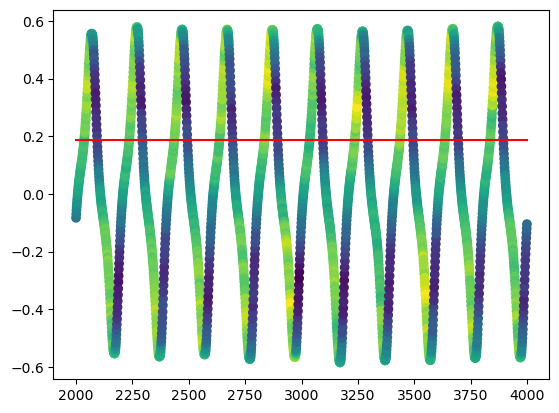

<Figure size 640x480 with 0 Axes>

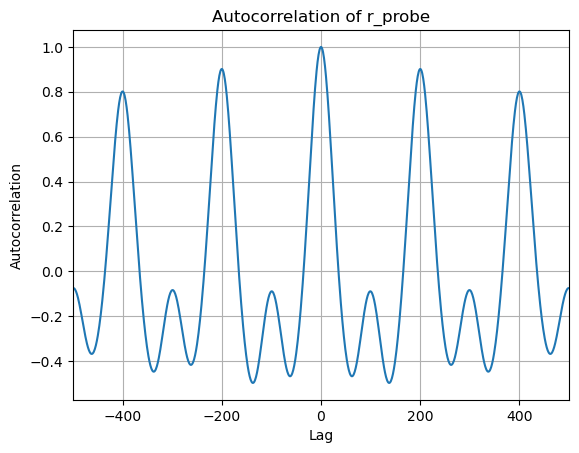

In [130]:
neuron_index = 53  # 53, 50
beta_index = neuron_index/100*np.pi*2-np.pi
start = int(numT/2)
bump_height = np.max(r_HD, axis = 1)
plt.scatter(time_steps[start:], center_HD[start:], c=bump_height[start:])

plt.plot(np.array([time_steps[start], time_steps[-1]]), np.array([beta_index, beta_index]), 'r')
plt.figure()
r_probe = r_HD[start:,neuron_index]

# 计算自相关
def autocorrelation(signal):
    n = len(signal)
    mean = np.mean(signal)
    var = np.var(signal)
    autocorr = np.correlate(signal - mean, signal - mean, mode='full') / (var * n)
    return autocorr

autocorr_r_probe = autocorrelation(r_probe)

# 定义时间轴
lags = np.arange(-len(r_probe) + 1, len(r_probe))

# 绘制自相关图
plt.figure()
plt.plot(lags, autocorr_r_probe)
plt.xlim(-500, 500)
plt.title('Autocorrelation of r_probe')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()